<a href="https://colab.research.google.com/github/IAT-ComputationalCreativity-Spring2025/Week11-Genetic-Algorithms/blob/main/DEAP_music_evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Music Evolution using DEAP

## Setup and imports:

In [3]:
# Install required libraries
! pip install deap midiutil numpy matplotlib

In [4]:
import random
from deap import base, creator, tools, algorithms
from midiutil import MIDIFile
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import os
import time

# Set random seed for reproducibility
random.seed(42)

## Define musical parameters

In [5]:
# Define the musical parameters
NOTE_RANGE = range(60, 73)  # C4 to C5 (middle C and one octave up)
SCALE_C_MAJOR = [60, 62, 64, 65, 67, 69, 71, 72]  # C major scale in MIDI notes
SCALE_A_MINOR = [57, 59, 60, 62, 64, 65, 67, 69]  # A minor scale

# Rhythm parameters
QUARTER_NOTE = 1.0
EIGHTH_NOTE = 0.5
HALF_NOTE = 2.0
WHOLE_NOTE = 4.0
RHYTHM_OPTIONS = [EIGHTH_NOTE, QUARTER_NOTE, HALF_NOTE]

# Structure parameters
NUM_MEASURES = 4
BEATS_PER_MEASURE = 4
MELODY_LENGTH = NUM_MEASURES * BEATS_PER_MEASURE  # Total beats

print("Available scales:")
print(f"C Major: {[n-60 for n in SCALE_C_MAJOR]} (as scale degrees)")
print(f"A Minor: {[n-57 for n in SCALE_A_MINOR]} (as scale degrees)")

Available scales:
C Major: [0, 2, 4, 5, 7, 9, 11, 12] (as scale degrees)
A Minor: [0, 2, 3, 5, 7, 8, 10, 12] (as scale degrees)


## Define the individual representation

In [6]:
# Define a class for our melody to encapsulate both pitch and duration
class Melody:
    def __init__(self, pitches=None, durations=None):
        if pitches is None:
            self.pitches = []
        else:
            self.pitches = pitches
            
        if durations is None:
            self.durations = []
        else:
            self.durations = durations
    
    def __len__(self):
        return len(self.pitches)
    
    def add_note(self, pitch, duration):
        self.pitches.append(pitch)
        self.durations.append(duration)
    
    def get_total_duration(self):
        return sum(self.durations)

# Create a custom class for our melody individual
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", Melody, fitness=creator.FitnessMax)

# Register the toolbox functions
toolbox = base.Toolbox()

# Initialization functions
def create_random_melody():
    ind = creator.Individual()
    current_duration = 0
    
    while current_duration < MELODY_LENGTH:
        # Select a note from the scale
        pitch = random.choice(SCALE_C_MAJOR)
        
        # Select a duration that won't exceed our melody length
        remaining = MELODY_LENGTH - current_duration
        possible_durations = [d for d in RHYTHM_OPTIONS if d <= remaining]
        
        if not possible_durations:
            # If no duration fits exactly, add a small note to fill the gap
            duration = remaining
        else:
            duration = random.choice(possible_durations)
        
        ind.add_note(pitch, duration)
        current_duration += duration
    
    return ind

# Register functions to create individuals and population
toolbox.register("individual", create_random_melody)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

## Define genetic operators

In [7]:
# Custom crossover function for melodies
def melody_crossover(ind1, ind2):
    """One-point crossover that ensures valid total duration"""
    if len(ind1) <= 1 or len(ind2) <= 1:
        return ind1.deepcopy(), ind2.deepcopy()
    
    # Find valid crossover points
    durations1 = ind1.durations
    durations2 = ind2.durations
    
    cum_duration1 = np.cumsum(durations1)
    cum_duration2 = np.cumsum(durations2)
    
    # Find points where both melodies have completed notes (avoid cutting notes)
    valid_points1 = list(cum_duration1)
    valid_points2 = list(cum_duration2)
    
    # Find a common crossover point that's not the end
    common_points = set(valid_points1).intersection(set(valid_points2))
    common_points = [p for p in common_points if p < MELODY_LENGTH]
    
    if not common_points:
        return ind1, ind2
    
    # Choose a common point
    crossover_point = random.choice(list(common_points))
    
    # Find indices where these cumulative durations occur
    idx1 = np.where(cum_duration1 == crossover_point)[0][0] + 1
    idx2 = np.where(cum_duration2 == crossover_point)[0][0] + 1
    
    # Create offspring
    child1 = creator.Individual()
    child1.pitches = ind1.pitches[:idx1] + ind2.pitches[idx2:]
    child1.durations = ind1.durations[:idx1] + ind2.durations[idx2:]
    
    child2 = creator.Individual()
    child2.pitches = ind2.pitches[:idx2] + ind1.pitches[idx1:]
    child2.durations = ind2.durations[:idx2] + ind1.durations[idx1:]
    
    return child1, child2

# Custom mutation function for melodies
def melody_mutation(individual, indpb_pitch=0.2, indpb_rhythm=0.1):
    """Mutation that separately handles pitches and durations"""
    # Pitch mutation
    for i in range(len(individual.pitches)):
        if random.random() < indpb_pitch:
            individual.pitches[i] = random.choice(SCALE_C_MAJOR)
    
    # Rhythm mutation (more complex to ensure we maintain total duration)
    if random.random() < indpb_rhythm and len(individual.durations) > 1:
        # Choose a random note to modify
        idx = random.randrange(len(individual.durations))
        current_duration = individual.durations[idx]
        
        # Choose a new rhythm value
        new_durations = [d for d in RHYTHM_OPTIONS if d != current_duration]
        if new_durations:
            new_duration = random.choice(new_durations)
            
            # Calculate the difference
            difference = current_duration - new_duration
            
            # If the new note is shorter, we need to add duration elsewhere
            if difference > 0:
                # Add a new note if possible
                if idx < len(individual.pitches) - 1:
                    individual.durations[idx] = new_duration
                    individual.durations[idx+1] += difference
                
            # If the new note is longer, we need to decrease duration elsewhere
            elif difference < 0:
                # Try to distribute the difference across other notes
                remaining_diff = -difference
                other_indices = [i for i in range(len(individual.durations)) if i != idx]
                random.shuffle(other_indices)
                
                for other_idx in other_indices:
                    if individual.durations[other_idx] > EIGHTH_NOTE:
                        # Can reduce this note
                        reduction = min(remaining_diff, individual.durations[other_idx] - EIGHTH_NOTE)
                        individual.durations[other_idx] -= reduction
                        remaining_diff -= reduction
                        
                        if remaining_diff <= 0:
                            # We've resolved the difference
                            individual.durations[idx] = new_duration
                            break
    
    return individual,

# Register our custom genetic operators
toolbox.register("mate", melody_crossover)
toolbox.register("mutate", melody_mutation, indpb_pitch=0.3, indpb_rhythm=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

## Define the fitness function

In [8]:
# Music theory-based fitness function
def evaluate_melody(individual):
    """Comprehensive music theory-based fitness function"""
    score = 0
    pitches = individual.pitches
    durations = individual.durations
    
    if not pitches:
        return 0,
    
    # 1. Reward for starting and ending on the tonic (C)
    if pitches[0] == 60:  # C is tonic of C major
        score += 3
    if pitches[-1] == 60:
        score += 3
    
    # 2. Reward for phrase structure (phrases often end on longer notes)
    phrase_structure_score = 0
    half_way_point = len(pitches) // 2
    
    # Check if midpoint has a longer note
    if half_way_point < len(durations) and durations[half_way_point] >= QUARTER_NOTE:
        phrase_structure_score += 2
        
    # Check if ending has a longer note
    if durations[-1] >= HALF_NOTE:
        phrase_structure_score += 3
        
    score += phrase_structure_score
    
    # 3. Penalize excessive repetition of the same note
    repetition_count = 0
    for i in range(1, len(pitches)):
        if pitches[i] == pitches[i-1]:
            repetition_count += 1
    
    # Some repetition is okay, but too much is boring
    if repetition_count > len(pitches) // 3:
        score -= (repetition_count - len(pitches) // 3)
    
    # 4. Reward interesting intervals but penalize large jumps
    interval_score = 0
    for i in range(len(pitches) - 1):
        interval = abs(pitches[i] - pitches[i+1])
        
        # Small to medium intervals are good
        if 0 < interval <= 4:  # Within a major third
            interval_score += 0.5
        elif 4 < interval <= 7:  # Within a fifth
            interval_score += 0.3
        # Large jumps (more than a fifth) are penalized, especially if frequent
        elif interval > 7:
            interval_score -= 0.8
            
    score += interval_score
            
    # 5. Reward melodic contour (ups and downs rather than monotonic)
    contour_score = 0
    direction_changes = 0
    
    current_direction = None
    for i in range(len(pitches) - 1):
        if pitches[i+1] > pitches[i]:
            new_direction = "up"
        elif pitches[i+1] < pitches[i]:
            new_direction = "down"
        else:
            new_direction = current_direction  # same note, no direction change
            
        if current_direction is not None and new_direction != current_direction:
            direction_changes += 1
            
        current_direction = new_direction
    
    # A good melody has some direction changes but not too many
    optimal_changes = len(pitches) // 3
    contour_score = 2 - min(2, abs(direction_changes - optimal_changes))
    
    score += contour_score * 2
    
    # 6. Reward rhythm variation
    unique_durations = len(set(durations))
    if unique_durations >= 2:
        score += unique_durations * 0.5
    
    # 7. Check for basic chord progressions (implied harmony)
    # Basic chord tones in C major: C(60), E(64), G(67)
    chord_tones = {
        'C': [60, 64, 67],  # C major
        'F': [65, 69, 60],  # F major
        'G': [67, 71, 62]   # G major
    }
    
    # Check if melody suggests common chord progressions
    implied_chords = []
    
    # Simplistic approach: look at important beats
    measure_points = [i*BEATS_PER_MEASURE for i in range(NUM_MEASURES)]
    
    current_time = 0
    note_idx = 0
    
    for measure in range(NUM_MEASURES):
        measure_start = measure * BEATS_PER_MEASURE
        
        # Find notes that fall in this measure
        measure_notes = []
        while note_idx < len(durations) and current_time < (measure+1) * BEATS_PER_MEASURE:
            measure_notes.append(pitches[note_idx])
            current_time += durations[note_idx]
            note_idx += 1
            
        # Check which chord fits best
        if measure_notes:
            best_chord = None
            best_match = -1
            
            for chord_name, chord_notes in chord_tones.items():
                match_count = sum(1 for note in measure_notes if note in chord_notes)
                if match_count > best_match:
                    best_match = match_count
                    best_chord = chord_name
            
            implied_chords.append(best_chord)
    
    # Reward common chord progressions
    if len(implied_chords) >= 2:
        # C-F, F-C, G-C are common progressions
        for i in range(len(implied_chords)-1):
            if (implied_chords[i] == 'C' and implied_chords[i+1] == 'F') or \
               (implied_chords[i] == 'F' and implied_chords[i+1] == 'C') or \
               (implied_chords[i] == 'G' and implied_chords[i+1] == 'C'):
                score += 2
    
    return score,

# Register the fitness function
toolbox.register("evaluate", evaluate_melody)

## Functions to create and visualize MIDI

In [9]:
# Function to create and save MIDI from a melody individual
def create_midi(melody, filename="evolved_melody.mid", tempo=100):
    midi = MIDIFile(1)  # One track
    track = 0
    time = 0
    
    midi.addTempo(track, time, tempo)
    
    # Add notes
    current_time = 0
    for pitch, duration in zip(melody.pitches, melody.durations):
        midi.addNote(track, 0, pitch, current_time, duration, 100)  # velocity=100
        current_time += duration
    
    # Write to file
    with open(filename, "wb") as output_file:
        midi.writeFile(output_file)
    
    return filename

# Function to play the MIDI file
def play_melody(melody):
    filename = create_midi(melody)
    return ipd.Audio(filename)

# Function to visualize the melody as a piano roll
def visualize_melody(melody, title="Evolved Melody"):
    pitches = melody.pitches
    durations = melody.durations
    
    if not pitches:
        return
    
    # Create a piano roll representation
    plt.figure(figsize=(12, 4))
    
    current_time = 0
    for pitch, duration in zip(pitches, durations):
        plt.plot([current_time, current_time + duration], [pitch, pitch], 'b-', linewidth=6)
        current_time += duration
    
    # Set the y-axis to show note names
    note_names = ['C4', 'C#4', 'D4', 'D#4', 'E4', 'F4', 'F#4', 'G4', 'G#4', 'A4', 'A#4', 'B4', 'C5']
    plt.yticks(range(60, 73), note_names)
    
    # Add grid lines for measures
    for measure in range(NUM_MEASURES + 1):
        plt.axvline(x=measure * BEATS_PER_MEASURE, color='gray', linestyle='--', alpha=0.5)
    
    plt.title(title)
    plt.xlabel('Time (beats)')
    plt.ylabel('Pitch')
    plt.grid(axis='y', alpha=0.3)
    plt.xlim(0, MELODY_LENGTH)
    plt.ylim(59, 73)
    plt.show()

# Function to display stats throughout evolution
def display_stats(logbook, title="Fitness Statistics"):
    gen = logbook.select("gen")
    fit_mins = logbook.select("min")
    fit_avgs = logbook.select("avg")
    fit_maxs = logbook.select("max")
    
    plt.figure(figsize=(10, 5))
    plt.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    plt.plot(gen, fit_avgs, "r-", label="Average Fitness")
    plt.plot(gen, fit_maxs, "g-", label="Maximum Fitness")
    
    plt.title(title)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.legend(loc="best")
    plt.grid(alpha=0.3)
    plt.show()

## Run the genetic algorithm

Evaluating initial population...
Generation 0: {'min': 1.4000000000000004, 'avg': 9.713333333333333, 'max': 18.7, 'std': 3.9659999439681735}
Generation 1: {'min': 7.9, 'avg': 13.043333333333331, 'max': 18.7, 'std': 3.70708181128439}
Generation 2: {'min': 8.7, 'avg': 17.409999999999993, 'max': 21.9, 'std': 2.91574461616011}
Generation 3: {'min': 11.8, 'avg': 18.646666666666665, 'max': 21.9, 'std': 1.9707415412027574}
Generation 4: {'min': 13.4, 'avg': 19.900000000000002, 'max': 22.9, 'std': 2.340512764331782}
Generation 5: {'min': 15.0, 'avg': 20.503333333333334, 'max': 22.9, 'std': 1.8909403892126149}

Best individual from generation 5:
Fitness: 22.9


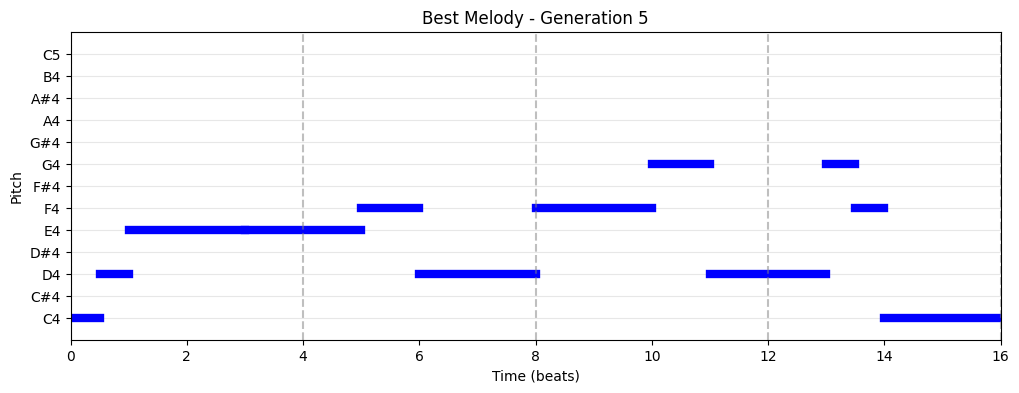

Generation 6: {'min': 12.6, 'avg': 20.283333333333335, 'max': 22.9, 'std': 2.2974019142404227}
Generation 7: {'min': 16.7, 'avg': 21.12666666666667, 'max': 23.1, 'std': 1.7684142300063326}
Generation 8: {'min': 20.799999999999997, 'avg': 22.38666666666667, 'max': 23.5, 'std': 0.8492087820763257}
Generation 9: {'min': 21.5, 'avg': 22.969999999999995, 'max': 23.5, 'std': 0.6240459384799593}
Generation 10: {'min': 18.4, 'avg': 23.040000000000003, 'max': 23.5, 'std': 0.927936779455727}

Best individual from generation 10:
Fitness: 23.5


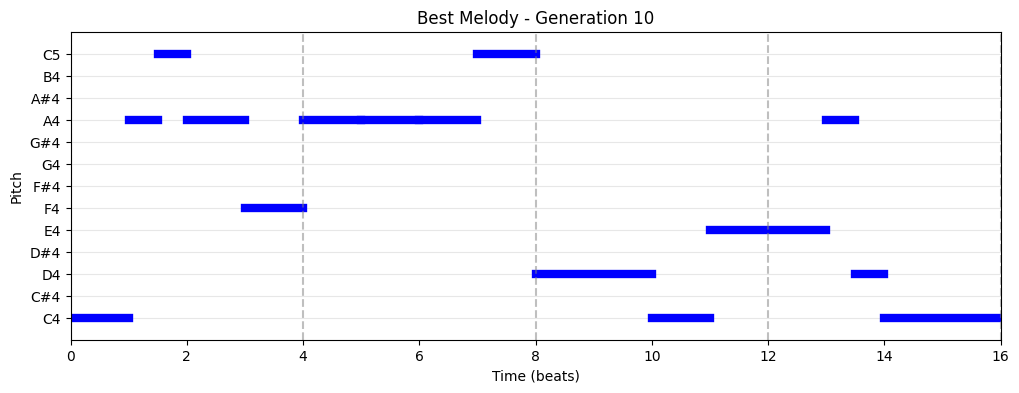

Generation 11: {'min': 22.9, 'avg': 23.66, 'max': 25.1, 'std': 0.6585843403341248}
Generation 12: {'min': 23.4, 'avg': 24.03666666666667, 'max': 25.1, 'std': 0.6247577308222949}
Generation 13: {'min': 23.0, 'avg': 24.46, 'max': 25.1, 'std': 0.6343500610861487}
Generation 14: {'min': 23.6, 'avg': 25.003333333333337, 'max': 26.299999999999997, 'std': 0.6008235089349351}
Generation 15: {'min': 24.5, 'avg': 25.200000000000003, 'max': 26.299999999999997, 'std': 0.5329165037789678}

Best individual from generation 15:
Fitness: 26.299999999999997


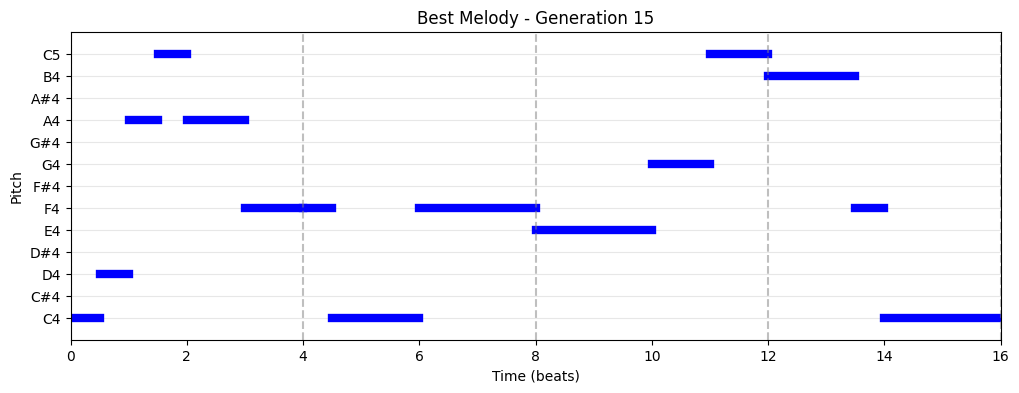

Generation 16: {'min': 24.5, 'avg': 25.226666666666674, 'max': 26.7, 'std': 0.6104279009205114}
Generation 17: {'min': 20.099999999999998, 'avg': 24.92, 'max': 26.299999999999997, 'std': 0.942479000650236}
Generation 18: {'min': 23.4, 'avg': 25.139999999999997, 'max': 26.3, 'std': 0.5845796210383435}
Generation 19: {'min': 25.1, 'avg': 25.37333333333333, 'max': 26.3, 'std': 0.42421168719821406}
Generation 20: {'min': 21.5, 'avg': 25.88333333333333, 'max': 27.1, 'std': 1.1108805316304522}

Best individual from generation 20:
Fitness: 27.1


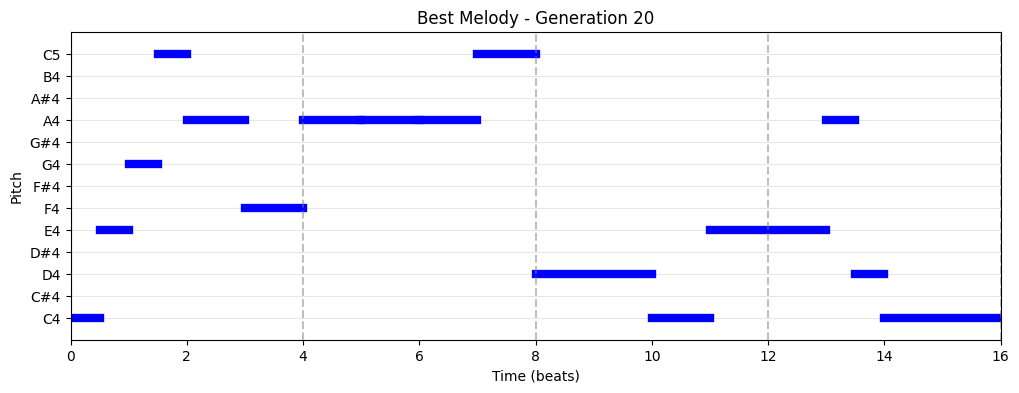

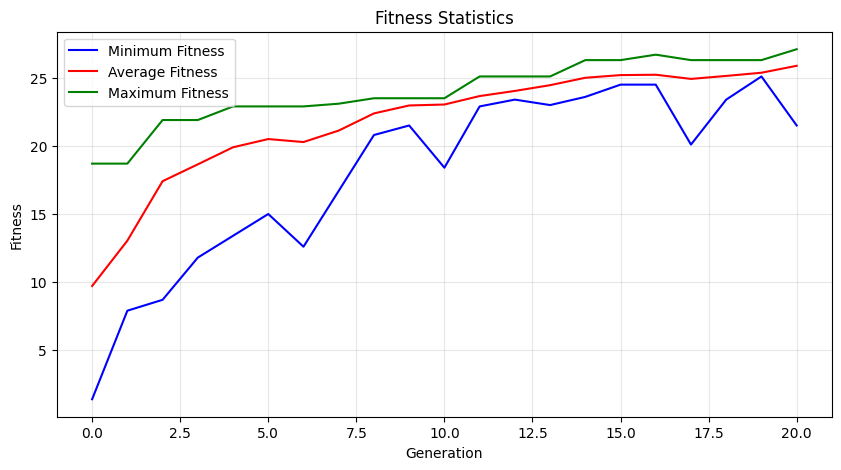

In [10]:
# GA parameters
POPULATION_SIZE = 30
NGEN = 20
CXPB = 0.7  # Crossover probability
MUTPB = 0.3  # Mutation probability

# Statistics setup
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
stats.register("max", np.max)
stats.register("std", np.std)

# Initialize hall of fame to keep track of best individuals
hof = tools.HallOfFame(5)

logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

# Create initial population
population = toolbox.population(n=POPULATION_SIZE)

# Evaluate initial population
print("Evaluating initial population...")
fitnesses = list(map(toolbox.evaluate, population))
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

# Store initial statistics
record = stats.compile(population)
logbook.record(gen=0, nevals=len(population), **record)
print(f"Generation 0: {record}")

# Iterate through generations
for gen in range(1, NGEN + 1):
    # Select and clone offspring
    offspring = algorithms.varAnd(population, toolbox, CXPB, MUTPB)
    
    # Evaluate offspring
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
    
    # Update hall of fame with current best individuals
    hof.update(offspring)
    
    # Select next generation
    population[:] = toolbox.select(offspring, len(population))
    
    # Store statistics
    record = stats.compile(population)
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    print(f"Generation {gen}: {record}")
    
    # Play best melody every 5 generations
    if gen % 5 == 0 or gen == NGEN:
        best_ind = tools.selBest(population, 1)[0]
        print(f"\nBest individual from generation {gen}:")
        print(f"Fitness: {best_ind.fitness.values[0]}")
        visualize_melody(best_ind, title=f"Best Melody - Generation {gen}")
        display(play_melody(best_ind))
        
# Display final statistics
display_stats(logbook)

## Examine and demonstrate the top melodies

Hall of Fame - Top 5 Melodies:

Melody #1
Fitness: 27.1
Number of notes: 16
Total duration: 16.0


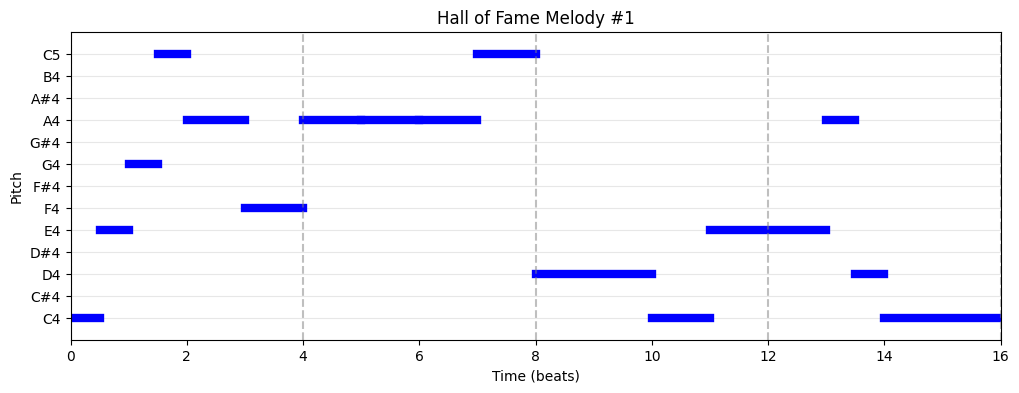


Melody #2
Fitness: 27.1
Number of notes: 16
Total duration: 16.0


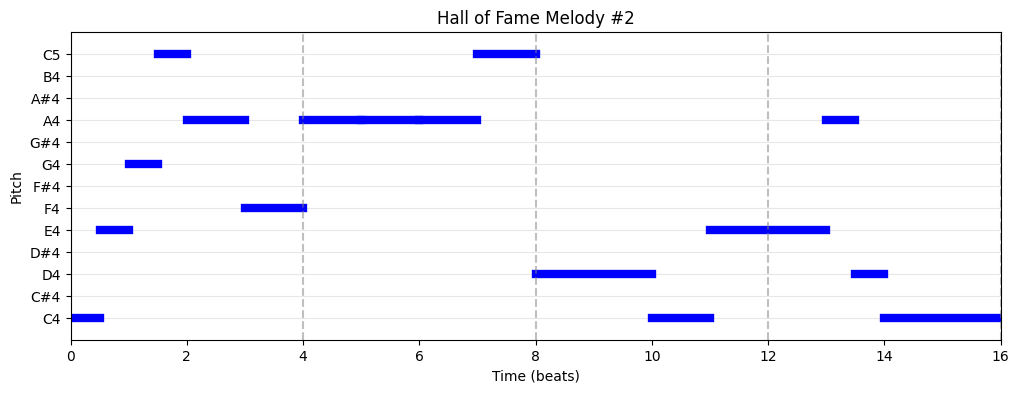


Melody #3
Fitness: 26.7
Number of notes: 15
Total duration: 16.0


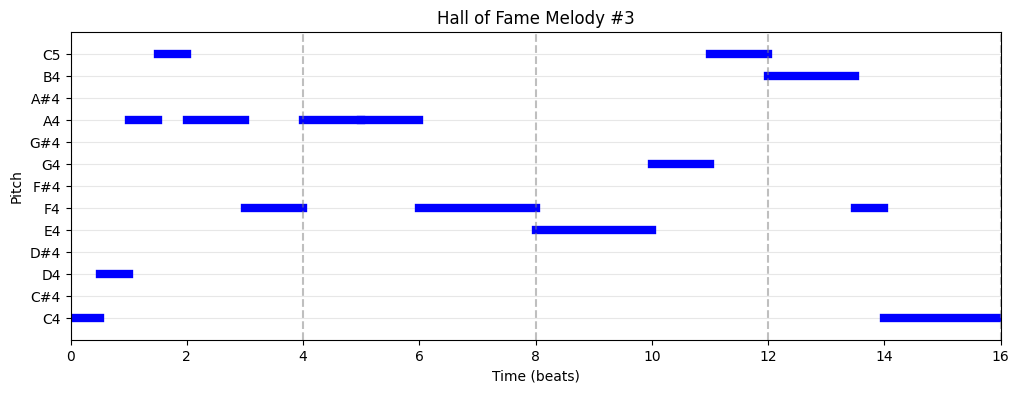


Melody #4
Fitness: 26.6
Number of notes: 16
Total duration: 16.0


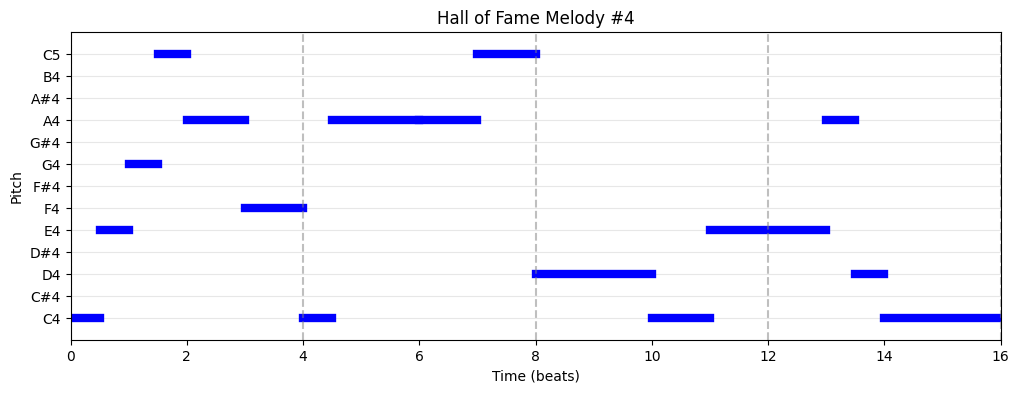


Melody #5
Fitness: 26.6
Number of notes: 16
Total duration: 16.0


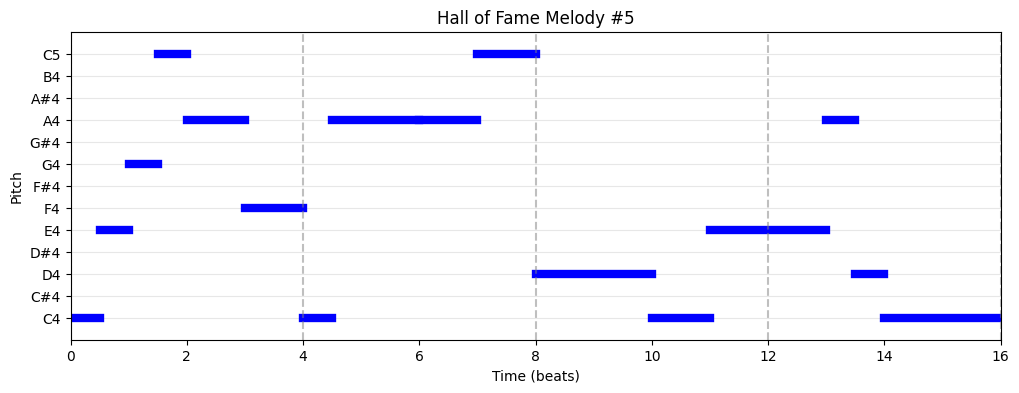

In [11]:
# Examine our hall of fame
print("Hall of Fame - Top 5 Melodies:")
for i, melody in enumerate(hof):
    print(f"\nMelody #{i+1}")
    print(f"Fitness: {melody.fitness.values[0]}")
    print(f"Number of notes: {len(melody.pitches)}")
    print(f"Total duration: {sum(melody.durations)}")
    
    # Display and play
    visualize_melody(melody, title=f"Hall of Fame Melody #{i+1}")
    display(play_melody(melody))
    
    # Small pause between playbacks
    time.sleep(1)